In [1]:
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import mean_squared_error
from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

In [5]:
import numpy as np

In [6]:
cd /home/angli/data/anglii/usersession-sample

/home/angli/data/anglii/usersession-sample


In [7]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import glob

In [8]:
from keras.models import load_model
from keras.callbacks import EarlyStopping

In [9]:
from datetime import datetime

## this is to prepare the data into input format

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### input data

In [11]:
l = [pd.read_csv(filename) for filename in glob.glob("/home/angli/data/anglii/usersession-sample/usersession-traintest-*.csv")]
df = pd.concat(l, axis=0)

In [12]:
df.columns.values

array(['user_id', 'week_num', 'Local_date', 'session_start2',
       'session_length2', 'start_Local_time', 'Hour_start', 'Hour_end',
       'podcast_played', 'Dow_num', 'user_gender_num',
       'user_age_group_num', 'freeUsers', 'acc_age', 'bf_num_tracks',
       'bf_num_artist', 'bf_music_secs', 'bf_music_streams',
       'bf_active_dates', 'bf_night_stream_secs', 'bf_EV_stream_secs',
       'bf_AF_stream_secs', 'bf_morning_stream_sec',
       'bf_weekend_stream_secs', 'bf_weekday_stream_secs',
       'window_num_songs', 'window_num_podcasts',
       'window_ms_songs_played', 'window_ms_podcasts_played',
       'window_mins_played', 'window_num_skipped',
       'window_num_non_skipped', 'window_num_from_home',
       'window_num_from_search', 'window_num_from_library',
       'window_num_from_browse', 'time_interval', 'rolling1dayPodcast',
       'rolling1weekPodcast', 'rolling1WindowPodcast',
       'rolling1WindowPodcast_msecs', 'rolling1dayPodcast_msecs',
       'rolling1weekPodc

In [13]:
df['test'].value_counts()#this is the feature to separate train/test

0    1912707
1     780695
Name: test, dtype: int64

### we want to sort the data into <user, time> order

In [14]:
df['session_start2'] = pd.to_datetime(df['session_start2'])

In [15]:
df = df.sort_values(by=['user_id', 'session_start2'])

In [16]:
df.head()

,user_id,week_num,Local_date,session_start2,session_length2,start_Local_time,Hour_start,Hour_end,podcast_played,Dow_num,...,rolling1week_library,rolling1Window_library,rolling1Window_home,rolling1Day_home,rolling1week_home,rolling1Window_search,rolling1Day_search,rolling1week_search,test,time_test
0,00155b865bdd419aa51704267038ac68,19,2019-05-06,2019-05-06 10:56:10.332,1787936,2019-05-06 06:00:49.754,6,6,0,1,...,0,0,0,0,0,0,0,0,0,0
1,00155b865bdd419aa51704267038ac68,19,2019-05-06,2019-05-06 11:29:43.879,226650,2019-05-06 06:29:43.879,6,6,0,1,...,0,0,0,0,0,0,0,0,0,0
2,00155b865bdd419aa51704267038ac68,19,2019-05-06,2019-05-06 11:48:16.112,270336,2019-05-06 06:52:45.274,6,6,0,1,...,0,0,0,0,0,0,0,0,0,0
3,00155b865bdd419aa51704267038ac68,19,2019-05-06,2019-05-06 11:55:13.351,113105,2019-05-06 06:55:13.351,6,6,0,1,...,0,0,0,0,0,0,0,0,0,0
4,00155b865bdd419aa51704267038ac68,19,2019-05-06,2019-05-06 23:07:03.438,1527371,2019-05-06 18:09:17.840,18,18,0,1,...,0,0,0,0,0,0,0,0,0,0


### we want to normalize the data

In [41]:
window_data = df[['user_gender_num', 'user_age_group_num', 'freeUsers', 'acc_age', 
                  'bf_num_tracks','bf_num_artist', 'bf_music_secs', 'bf_music_streams',
                  'bf_active_dates', 'bf_night_stream_secs', 
                  'bf_EV_stream_secs','bf_AF_stream_secs', 'bf_morning_stream_sec', 'bf_weekend_stream_secs', 
                  'bf_weekday_stream_secs','week_num','Dow_num', 'Hour_start', 'time_interval',
                  'Hour_end',
                  'window_num_songs', 'window_num_podcasts','window_ms_songs_played', 'window_ms_podcasts_played',
                  'window_mins_played', 'window_num_skipped','window_num_non_skipped', 
                  'window_num_from_home', 'window_num_from_search', 'window_num_from_library', 'window_num_from_browse']]

In [42]:
len(window_data.columns.values)

31

In [43]:
values = window_data.values

In [44]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [45]:
scaled.shape

(2693402, 31)

### adding back the user_id, train/test, Y = 'podcast_played'

In [46]:
adding = np.array(df[['user_id',"test",'podcast_played']])
#adding = np.array(df[["test",'podcast_played']])
adding

array([['00155b865bdd419aa51704267038ac68', 0, 0],
       ['00155b865bdd419aa51704267038ac68', 0, 0],
       ['00155b865bdd419aa51704267038ac68', 0, 0],
       ...,
       ['fff27371344540b2b69bd765a87e1a89', 0, 1],
       ['fff27371344540b2b69bd765a87e1a89', 0, 1],
       ['fff27371344540b2b69bd765a87e1a89', 0, 1]], dtype=object)

In [47]:
id_scaled = np.append(scaled, adding, 1)

In [48]:
id_scaled

array([[0.0, 0.2857142984867096, 0.0, ...,
        '00155b865bdd419aa51704267038ac68', 0, 0],
       [0.0, 0.2857142984867096, 0.0, ...,
        '00155b865bdd419aa51704267038ac68', 0, 0],
       [0.0, 0.2857142984867096, 0.0, ...,
        '00155b865bdd419aa51704267038ac68', 0, 0],
       ...,
       [1.0, 0.2857142984867096, 1.0, ...,
        'fff27371344540b2b69bd765a87e1a89', 0, 1],
       [1.0, 0.2857142984867096, 1.0, ...,
        'fff27371344540b2b69bd765a87e1a89', 0, 1],
       [1.0, 0.2857142984867096, 1.0, ...,
        'fff27371344540b2b69bd765a87e1a89', 0, 1]], dtype=object)

In [49]:
id_scaled.shape 
#column 0-31 are the features
#the last 3 (32,33,34) columns are the newly added: "user_id", test",'podcast_played'

(2693402, 34)

### Prepare the input to keras: 
#### make into sequential data: 
#### s(t-7), s(t-6), s(t-5), s(t-4), s(t-3), s(t-2), s(t-1), s(t) | y(t) 

In [50]:
# frame as supervised learning
reframed = series_to_supervised(id_scaled, 7, 1)

In [1]:
#reframed.columns.values

In [52]:
#Var1-31: user, current window
#var32: user_id
#var33: test=1; -- no need for t-n
#var34: Y: Podcastplayed -delete for t

#reframed["var31(t)"].value_counts()
reframed["var31(t)"].value_counts()

0.000000    2692155
0.009524        595
0.019048        109
0.038095         54
0.028571         50
             ...   
0.304762          1
0.780952          1
0.495238          1
0.390476          1
0.447619          1
Name: var31(t), Length: 65, dtype: int64

### select only with sequences belonged to the same user

In [53]:
#determine selection of rows --past rows belong to same user, remove the data descrepency
#reframed["selection"] = 1
reframed['select'] = reframed["var32(t)"]==reframed["var32(t-7)"]

In [54]:
reframed = reframed[reframed["select"]==True]

In [55]:
reframed["select"].value_counts()

True    2647849
Name: select, dtype: int64

In [56]:
#column var1-31 are the features: 7 time steps back * (31 features)
#the last 3 (32,33,34) columns are the newly added: "user_id", test",'podcast_played'

In [83]:
X_features = ['var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)',
       'var6(t-7)', 'var7(t-7)', 'var8(t-7)', 'var9(t-7)', 'var10(t-7)',
       'var11(t-7)', 'var12(t-7)', 'var13(t-7)', 'var14(t-7)',
       'var15(t-7)', 'var16(t-7)', 'var17(t-7)', 'var18(t-7)',
       'var19(t-7)', 'var20(t-7)', 'var21(t-7)', 'var22(t-7)',
       'var23(t-7)', 'var24(t-7)', 'var25(t-7)', 'var26(t-7)',
       'var27(t-7)', 'var28(t-7)', 'var29(t-7)', 'var30(t-7)',
       'var31(t-7)', 
       'var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)',
       'var6(t-6)', 'var7(t-6)', 'var8(t-6)', 'var9(t-6)', 'var10(t-6)',
       'var11(t-6)', 'var12(t-6)', 'var13(t-6)', 'var14(t-6)',
       'var15(t-6)', 'var16(t-6)', 'var17(t-6)', 'var18(t-6)',
       'var19(t-6)', 'var20(t-6)', 'var21(t-6)', 'var22(t-6)',
       'var23(t-6)', 'var24(t-6)', 'var25(t-6)', 'var26(t-6)',
       'var27(t-6)', 'var28(t-6)', 'var29(t-6)', 'var30(t-6)',
       'var31(t-6)', 
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var12(t-5)', 'var13(t-5)', 'var14(t-5)',
       'var15(t-5)', 'var16(t-5)', 'var17(t-5)', 'var18(t-5)',
       'var19(t-5)', 'var20(t-5)', 'var21(t-5)', 'var22(t-5)',
       'var23(t-5)', 'var24(t-5)', 'var25(t-5)', 'var26(t-5)',
       'var27(t-5)', 'var28(t-5)', 'var29(t-5)', 'var30(t-5)',
       'var31(t-5)', 
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)',
       'var11(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)',
       'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)',
       'var19(t-4)', 'var20(t-4)', 'var21(t-4)', 'var22(t-4)',
       'var23(t-4)', 'var24(t-4)', 'var25(t-4)', 'var26(t-4)',
       'var27(t-4)', 'var28(t-4)', 'var29(t-4)', 'var30(t-4)',
       'var31(t-4)', 
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)',
       'var11(t-3)', 'var12(t-3)', 'var13(t-3)', 'var14(t-3)',
       'var15(t-3)', 'var16(t-3)', 'var17(t-3)', 'var18(t-3)',
       'var19(t-3)', 'var20(t-3)', 'var21(t-3)', 'var22(t-3)',
       'var23(t-3)', 'var24(t-3)', 'var25(t-3)', 'var26(t-3)',
       'var27(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)',
       'var31(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)',
       'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var14(t-2)',
       'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)',
       'var19(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)',
       'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)',
       'var27(t-2)', 'var28(t-2)', 'var29(t-2)', 'var30(t-2)',
       'var31(t-2)', 
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)',
       'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)',
       'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)',
       'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)',
       'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)',
       'var31(t-1)', 
       'var1(t)','var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)',
       'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)',
       'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)',
       'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)',
       'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)',
       'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)']

In [58]:
Y_feature = 'var34(t)'

In [59]:
reframed['var20(t)'] = 0
reframed['var21(t)'] = 0
reframed['var22(t)'] = 0
reframed['var23(t)'] = 0
reframed['var24(t)'] = 0
reframed['var25(t)'] = 0
reframed['var26(t)'] = 0
reframed['var27(t)'] = 0
reframed['var28(t)'] = 0
reframed['var29(t)'] = 0
reframed['var30(t)'] = 0
reframed['var31(t)'] = 0

In [61]:
reframed['var31(t)']

7          0
8          0
9          0
10         0
11         0
          ..
2693397    0
2693398    0
2693399    0
2693400    0
2693401    0
Name: var31(t), Length: 2647849, dtype: int64

In [62]:
reframed_final = reframed[['var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)',
       'var6(t-7)', 'var7(t-7)', 'var8(t-7)', 'var9(t-7)', 'var10(t-7)',
       'var11(t-7)', 'var12(t-7)', 'var13(t-7)', 'var14(t-7)',
       'var15(t-7)', 'var16(t-7)', 'var17(t-7)', 'var18(t-7)',
       'var19(t-7)', 'var20(t-7)', 'var21(t-7)', 'var22(t-7)',
       'var23(t-7)', 'var24(t-7)', 'var25(t-7)', 'var26(t-7)',
       'var27(t-7)', 'var28(t-7)', 'var29(t-7)', 'var30(t-7)',
       'var31(t-7)', 
       'var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)',
       'var6(t-6)', 'var7(t-6)', 'var8(t-6)', 'var9(t-6)', 'var10(t-6)',
       'var11(t-6)', 'var12(t-6)', 'var13(t-6)', 'var14(t-6)',
       'var15(t-6)', 'var16(t-6)', 'var17(t-6)', 'var18(t-6)',
       'var19(t-6)', 'var20(t-6)', 'var21(t-6)', 'var22(t-6)',
       'var23(t-6)', 'var24(t-6)', 'var25(t-6)', 'var26(t-6)',
       'var27(t-6)', 'var28(t-6)', 'var29(t-6)', 'var30(t-6)',
       'var31(t-6)', 
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var12(t-5)', 'var13(t-5)', 'var14(t-5)',
       'var15(t-5)', 'var16(t-5)', 'var17(t-5)', 'var18(t-5)',
       'var19(t-5)', 'var20(t-5)', 'var21(t-5)', 'var22(t-5)',
       'var23(t-5)', 'var24(t-5)', 'var25(t-5)', 'var26(t-5)',
       'var27(t-5)', 'var28(t-5)', 'var29(t-5)', 'var30(t-5)',
       'var31(t-5)', 
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)',
       'var11(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)',
       'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)',
       'var19(t-4)', 'var20(t-4)', 'var21(t-4)', 'var22(t-4)',
       'var23(t-4)', 'var24(t-4)', 'var25(t-4)', 'var26(t-4)',
       'var27(t-4)', 'var28(t-4)', 'var29(t-4)', 'var30(t-4)',
       'var31(t-4)', 
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)',
       'var11(t-3)', 'var12(t-3)', 'var13(t-3)', 'var14(t-3)',
       'var15(t-3)', 'var16(t-3)', 'var17(t-3)', 'var18(t-3)',
       'var19(t-3)', 'var20(t-3)', 'var21(t-3)', 'var22(t-3)',
       'var23(t-3)', 'var24(t-3)', 'var25(t-3)', 'var26(t-3)',
       'var27(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)',
       'var31(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)',
       'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var14(t-2)',
       'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)',
       'var19(t-2)', 'var20(t-2)', 'var21(t-2)', 'var22(t-2)',
       'var23(t-2)', 'var24(t-2)', 'var25(t-2)', 'var26(t-2)',
       'var27(t-2)', 'var28(t-2)', 'var29(t-2)', 'var30(t-2)',
       'var31(t-2)', 
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)',
       'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)',
       'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)',
       'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)',
       'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)',
       'var31(t-1)', 
       'var1(t)','var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)',
       'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)',
       'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)',
       'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)',
       'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)',
       'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)',
        'var33(t)', 'var34(t)']] 

In [63]:
#this is the prediction of Y
reframed_final['var34(t)'].value_counts()

0    2437428
1     210421
Name: var34(t), dtype: int64

In [64]:
210421/(210421 + 2437428)

0.07946865550112563

In [65]:
#this is the training/test
reframed_final['var33(t)'].value_counts()

0    1880693
1     767156
Name: var33(t), dtype: int64

In [66]:
1880693/(1880693+767156)

0.7102719981388667

### split train/test

In [67]:
train = reframed_final[reframed_final['var33(t)']==0]
test = reframed_final[reframed_final['var33(t)']==1]

In [68]:
train['var34(t)'].value_counts()

0    1729062
1     151631
Name: var34(t), dtype: int64

In [69]:
test['var34(t)'].value_counts()

0    708366
1     58790
Name: var34(t), dtype: int64

In [70]:
708366/(708366+58790)

0.9233663035940539

In [71]:
print(train.shape, test.shape)

(1880693, 250) (767156, 250)


In [72]:
#31(vars)*7(step back)=217

In [84]:
X_train = train[X_features].values; 
Y_train = train['var34(t)'].values

In [85]:
print(X_train.shape, Y_train.shape)

(1880693, 248) (1880693,)


In [86]:
X_test = test[X_features].values; 
Y_test = test['var34(t)'].values

In [87]:
print(X_test.shape, Y_test.shape)

(767156, 248) (767156,)


In [88]:
#let's reshape to (nsample, time steps, nfeatures)

In [89]:
train_X = X_train.reshape((X_train.shape[0], 8, 31))
test_X = X_test.reshape((X_test.shape[0], 8, 31))

In [90]:
print(train_X.shape, Y_train.shape, test_X.shape, Y_test.shape)

(1880693, 8, 31) (1880693,) (767156, 8, 31) (767156,)


## model structure

In [91]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [57]:
## they don't have recall, precision, f1
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [95]:
model = Sequential()

In [96]:
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))

In [97]:
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [65]:
#adam = optimizers.Adam(lr=0.0001)

In [66]:
#model.compile(optimizer='adam', loss='binary_crossentropy',
              #metrics=['acc',f1_m,precision_m, recall_m])

In [98]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['acc'])

W0811 04:30:27.471926 140408490039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 04:30:27.494667 140408490039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0811 04:30:27.500135 140408490039040 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [68]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               109200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 109,351
Trainable params: 109,351
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
cp = ModelCheckpoint(filepath="/home/angli/model/lstm_model_tn8.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/home/angli/model/lstm_model_tn1_logs/summarytn8',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

overfitCallback = EarlyStopping(monitor='val_loss', min_delta=0, patience = 5, mode='auto')

In [100]:
history = model.fit(train_X, Y_train, validation_split=0.20, epochs=20, batch_size=100, callbacks=[cp, tb, overfitCallback])#batch_size=64

Train on 1504554 samples, validate on 376139 samples


W0811 04:31:19.076088 140408490039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0811 04:31:19.077444 140408490039040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
1504554/1504554 [==============================] - 1002s 666us/step - loss: 0.1505 - acc: 0.9509 - val_loss: 0.1326 - val_acc: 0.9579
Epoch 2/20
1504554/1504554 [==============================] - 958s 637us/step - loss: 0.1287 - acc: 0.9599 - val_loss: 0.1347 - val_acc: 0.9571
Epoch 3/20
1504554/1504554 [==============================] - 982s 653us/step - loss: 0.1242 - acc: 0.9615 - val_loss: 0.1251 - val_acc: 0.9609
Epoch 4/20
1504554/1504554 [==============================] - 964s 641us/step - loss: 0.1216 - acc: 0.9621 - val_loss: 0.1255 - val_acc: 0.9600
Epoch 5/20
1504554/1504554 [==============================] - 939s 624us/step - loss: 0.1199 - acc: 0.9625 - val_loss: 0.1227 - val_acc: 0.9617
Epoch 6/20
1504554/1504554 [==============================] - 926s 615us/step - loss: 0.1183 - acc: 0.9629 - val_loss: 0.1226 - val_acc: 0.9612
Epoch 7/20
1504554/1504554 [==============================] - 977s 649us/step - loss: 0.1171 - acc: 0.9631 - val_loss: 0.1223 - val_acc

In [62]:
model = load_model("/home/angli/model/lstm_model_tn8.h5")

W0808 16:50:48.460108 139863304599296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 16:50:50.366657 139863304599296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 16:50:50.376963 139863304599296 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [63]:
history = model.fit(train_X, Y_train, validation_split=0.20, epochs=10, batch_size=100, callbacks=[cp, tb])#batch_size=64

W0808 16:51:00.982039 139863304599296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0808 16:51:00.983141 139863304599296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Train on 1504554 samples, validate on 376139 samples
Epoch 1/10
1504554/1504554 [==============================] - 1800s 1ms/step - loss: 0.1290 - acc: 0.9601 - val_loss: 0.1305 - val_acc: 0.9597
Epoch 2/10
1504554/1504554 [==============================] - 1951s 1ms/step - loss: 0.1274 - acc: 0.9608 - val_loss: 0.1305 - val_acc: 0.9596
Epoch 3/10
1504554/1504554 [==============================] - 1944s 1ms/step - loss: 0.1261 - acc: 0.9614 - val_loss: 0.1290 - val_acc: 0.9608
Epoch 4/10
1504554/1504554 [==============================] - 1896s 1ms/step - loss: 0.1251 - acc: 0.9617 - val_loss: 0.1284 - val_acc: 0.9608
Epoch 5/10
1504554/1504554 [==============================] - 1819s 1ms/step - loss: 0.1244 - acc: 0.9619 - val_loss: 0.1286 - val_acc: 0.9611
Epoch 6/10
1504554/1504554 [==============================] - 1770s 1ms/step - loss: 0.1239 - acc: 0.9622 - val_loss: 0.1290 - val_acc: 0.9610
Epoch 7/10
1504554/1504554 [==============================] - 1825s 1ms/step - loss: 0.12

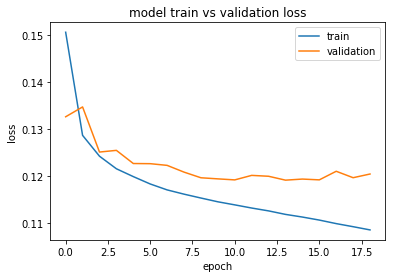

In [101]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [102]:
y_test_pred = model.predict(test_X, batch_size=2000, verbose=1)
y_train_pred = model.predict(train_X, batch_size=2000, verbose=1)

1880693/1880693 [==============================] - 161s 86us/step


In [103]:
#need to flattern and convert the results into numerical

In [104]:
y_test_pred_flatterned = np.array([i[0] for i in y_test_pred])
y_train_pred_flatterned = np.array([i[0] for i in y_train_pred])

In [105]:
Y_train_num = np.array([i for i in Y_train])
Y_test_num = np.array([i for i in Y_test])

In [106]:
#final the optimal threshold

In [107]:
y_test_pred_ = 1*(y_test_pred_flatterned >= 0.5)
y_train_pred_ = 1*(y_train_pred_flatterned >= 0.5)

In [108]:
y_test_pred_

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
print ("Model Train Recall is %2f\n" % (recall_score(Y_train_num, y_train_pred_)))
print ("Model Train Precision is %2f\n" % (precision_score(Y_train_num, y_train_pred_)))
print ("Model Train F1-SCORE is %2f\n" % (f1_score(Y_train_num, y_train_pred_)))
print ("Model Train Accuracy_score is %2f\n" % (accuracy_score(Y_train_num, y_train_pred_)))
print ("Model AUC is %2f\n" % (roc_auc_score(Y_train_num, y_train_pred_)))
print ("Model Train cf: \n", confusion_matrix(Y_train_num, y_train_pred_))

Model Train Recall is 0.689437

Model Train Precision is 0.840834

Model Train F1-SCORE is 0.757646

Model Train Accuracy_score is 0.964439

Model AUC is 0.838996

Model Train cf: 
 [[1709273   19789]
 [  47091  104540]]


In [110]:
print ("Model Testing Recall is %2f\n" % (recall_score(Y_test_num, y_test_pred_)))
print ("Model Testing Precision is %2f\n" % (precision_score(Y_test_num, y_test_pred_)))
print ("Model Testing F1-SCORE is %2f\n" % (f1_score(Y_test_num, y_test_pred_)))
print ("Model Testing Accuracy_score is %2f\n" % (accuracy_score(Y_test_num, y_test_pred_)))
print ("Model AUC is %2f\n" % (roc_auc_score(Y_test_num, y_test_pred_flatterned)))
print ("Model Test cf: \n", confusion_matrix(Y_test_num, y_test_pred_))

Model Testing Recall is 0.659398

Model Testing Precision is 0.812006

Model Testing F1-SCORE is 0.727788

Model Testing Accuracy_score is 0.962199

Model AUC is 0.947691

Model Test cf: 
 [[699391   8975]
 [ 20024  38766]]


In [111]:
model = load_model("/home/angli/model/lstm_model_tn8.h5")

In [112]:
y_test_pred = model.predict(test_X, batch_size=2000, verbose=1)
y_train_pred = model.predict(train_X, batch_size=2000, verbose=1)

1880693/1880693 [==============================] - 124s 66us/step


In [113]:
y_test_pred_flatterned = np.array([i[0] for i in y_test_pred])
y_train_pred_flatterned = np.array([i[0] for i in y_train_pred])

In [114]:
Y_train_num = np.array([i for i in Y_train])
Y_test_num = np.array([i for i in Y_test])

In [115]:
y_test_pred_ = 1*(y_test_pred_flatterned >= 0.5)
y_train_pred_ = 1*(y_train_pred_flatterned >= 0.5)

In [116]:
print ("Model Train Recall is %2f\n" % (recall_score(Y_train_num, y_train_pred_)))
print ("Model Train Precision is %2f\n" % (precision_score(Y_train_num, y_train_pred_)))
print ("Model Train F1-SCORE is %2f\n" % (f1_score(Y_train_num, y_train_pred_)))
print ("Model Train Accuracy_score is %2f\n" % (accuracy_score(Y_train_num, y_train_pred_)))
print ("Model AUC is %2f\n" % (roc_auc_score(Y_train_num, y_train_pred_)))
print ("Model Train cf: \n", confusion_matrix(Y_train_num, y_train_pred_))

Model Train Recall is 0.686014

Model Train Precision is 0.836309

Model Train F1-SCORE is 0.753743

Model Train Accuracy_score is 0.963859

Model AUC is 0.837119

Model Train cf: 
 [[1708702   20360]
 [  47610  104021]]


In [117]:
print ("Model Testing Recall is %2f\n" % (recall_score(Y_test_num, y_test_pred_)))
print ("Model Testing Precision is %2f\n" % (precision_score(Y_test_num, y_test_pred_)))
print ("Model Testing F1-SCORE is %2f\n" % (f1_score(Y_test_num, y_test_pred_)))
print ("Model Testing Accuracy_score is %2f\n" % (accuracy_score(Y_test_num, y_test_pred_)))
print ("Model AUC is %2f\n" % (roc_auc_score(Y_test_num, y_test_pred_flatterned)))
print ("Model Test cf: \n", confusion_matrix(Y_test_num, y_test_pred_))

Model Testing Recall is 0.660844

Model Testing Precision is 0.814674

Model Testing F1-SCORE is 0.729740

Model Testing Accuracy_score is 0.962489

Model AUC is 0.947099

Model Test cf: 
 [[699528   8838]
 [ 19939  38851]]


### save the model

In [65]:
cd /home/angli/model

/home/angli/model


In [66]:
# serialize model to JSON
model_json = model.to_json()
with open("model_tn1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_tn1.h5")
print("Saved model to disk")

Saved model to disk


In [67]:
# later...
 # load json and create model
json_file = open('model_tn1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [68]:
from keras.models import model_from_json

In [69]:
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_tn1.h5")
print("Loaded model from disk")

Loaded model from disk


In [73]:
adam = optimizers.Adam(lr=0.0001)

In [74]:
 # evaluate loaded model on test data
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',precision_m, recall_m])

In [75]:
cp = ModelCheckpoint(filepath="lstm_model_tn1_v2.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)